In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import time

import scipy as scp
import sklearn
import sys, os, pickle

sys.path.append(os.path.join('..'))


from GSTAR.utils import *
# from GSTAR.parser import * 
from GSTAR.model import *
from GSTAR.metric_util import *
from GSTAR.image_dataloader import *
# from GSTAR.data_util import *

from sklearn.model_selection import train_test_split
from scipy.io import savemat

import torch, torchvision

from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.utils as vutils

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load path data

In [ ]:
DATANAME = 'celebA'

In [32]:
# file_path y a
train_path = '../dataset/train_data.txt'
valid_path = '../dataset/val_data.txt'
test_path = '../dataset/test_data.txt'

Setup for the dataset

In [33]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# mean = [0.5, 0.5, 0.5]
# std = [0.5, 0.5, 0.5]
normalize = transforms.Normalize(mean=mean, std=std)
        
ts = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
       ])

train_data = CelebADataset(train_path, transform = ts)
valid_data = CelebADataset(valid_path, transform = ts)
test_data = CelebADataset(test_path, transform = ts)

In [34]:
batch_size = 64
workers = 12


trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [35]:
opt = {'cuda':'1', 'random_seed':0, 'experiment':'celeba', 'print_freq':50, 'batch_size':32, 'total_epochs':50, 
      'output_dim':1, 'save_log':True}

opt['save_folder'] = os.path.join('../experiments/', opt['experiment'])
opt['device'] = torch.device('cuda:' + opt['cuda'])

if not os.path.exists(opt['save_folder']):
    os.makedirs(opt['save_folder'])

optimizer_setting = {
    'optimizer':torch.optim.Adam,
    'lr':1e-4,
    'weight_decay': 0
}
opt['optimizer_setting']=optimizer_setting
opt['dropout']=0.5

# Load ResNet

In [36]:
GSTAR_model = ImageModel(opt)

Test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


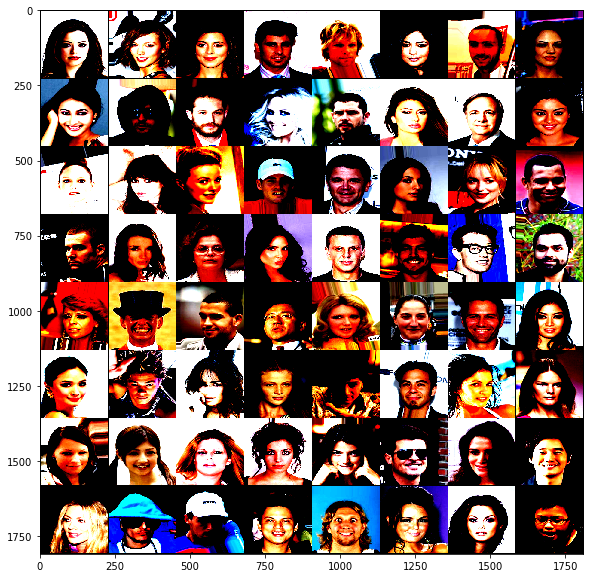

In [37]:
x, s, y = iter(trainloader).next()
x, s, y = x.to(opt['device']), s.to(opt['device']), y.to(opt['device'])
show_img(x)

load saved ResNet Model

In [13]:
per_dict = GSTAR_model.test(testloader, 'best.pth')

ACC : 0.820, Priv ACC : 0.826, Unpriv ACC : 0.815
TPR : 0.809, Priv TPR : 0.613, Unpriv TPR : 0.890
FPR : 0.169, Priv FPR : 0.092, Unpriv FPR : 0.341


Original Distribution of confusion matrix

In [14]:
complete_dict(per_dict)
per_dict

{'TP_priv': 1704.0,
 'FN_priv': 1077.0,
 'FP_priv': 665.0,
 'TN_priv': 6554.0,
 'TP_unpriv': 6006.0,
 'FN_unpriv': 745.0,
 'FP_unpriv': 665.0,
 'TN_unpriv': 2142.0,
 'FP': 1330.0,
 'TP': 7710.0,
 'FN': 1822.0,
 'TN': 8696.0}

Dataloader

In [18]:
trainloader_GSTAR = torch.utils.data.DataLoader(train_data, batch_size=64,
                                         shuffle=True, num_workers=workers)
validloader_GSTAR = torch.utils.data.DataLoader(valid_data, batch_size=64,
                                         shuffle=True, num_workers=workers)
testloader_GSTAR = torch.utils.data.DataLoader(test_data, batch_size=64,
                                         shuffle=True, num_workers=workers)

In [38]:
train_logit, train_sens, train_label, train_x, \
valid_logit, valid_sens, valid_label, valid_x, \
test_logit, test_sens, test_label, test_x = gen_samples(opt, trainloader_GSTAR, validloader_GSTAR, testloader_GSTAR)

# Train GSTAR on EOd constraint

In [26]:
theta_0 = np.zeros((2,1))
iter_num = 50
c = np.array([0, 1, 1, 0, 0, 1, 1, 0]).reshape(-1,1)

verbose_iter = 1e5

logit_shape = True

if logit_shape:
    theta_0 = np.zeros((2,1))
else:
    theta_0 = np.zeros((2,1))+0.5

A_config, sample_config, dist_config = gen_config(train_logit, train_sens, train_label, DATANAME, verbose = False)
A_config_valid, sample_valid, dist_valid = gen_config(valid_logit, valid_sens, valid_label, DATANAME, verbose = False)
A_config_test, sample_test, dist_test = gen_config(test_logit, test_sens, test_label, DATANAME, verbose = False)


tic = time.time()
for cnst_name in ['EOd']:
    if type(cnst_name) == list:
        A = np.concatenate([A_config['A_{}'.format(k)] for k in cnst_name], 1)
        A_valid = np.concatenate([A_config_valid['A_{}'.format(k)] for k in cnst_name], 1)

        for i, cnst in enumerate(cnst_name):
            if i == 0:
                name = cnst
            else:
                name += '+'+cnst
    else:
        A = A_config['A_{}'.format(cnst_name)]
        A_valid = A_config_valid['A_{}'.format(cnst_name)]
        name = cnst_name

    print(name)

    train_config = {'A' : A, 'sample_config' : sample_config, 'dist_config' : dist_config}
    valid_config = {'A' : A_valid, 'sample_config' : sample_valid, 'dist_config' : dist_valid}


    lamda = 1e2

    theta_best, theta_end = alternative_train(theta_0.copy(), train_config, valid_config, c, lamda, iter_num, verbose_iter, verbose = False, show_fig = False)

print(time.time() - tic)


{'n00': 1181, 'n01': 1939, 'n10': 2495, 'n11': 785}
{'n00': 1277, 'n01': 1744, 'n10': 2691, 'n11': 688}
{'n00': 522, 'n01': 1165, 'n10': 1084, 'n11': 429}
EOd
0.28891801834106445


In [31]:
print('GSTAR Result')
z_end, ACC_end = evaluate(test_logit, test_label, test_sens, theta_end, verbose = True, logit_form = logit_shape)


print('Original Result')
if logit_shape:
    z_orig, ACC_orig =  evaluate(test_logit, test_label, test_sens, np.zeros((2,1)), verbose = True, logit_form = logit_shape)

GSTAR Result
overall TPR : 0.668
priv TPR : 0.676
unpriv TPR : 0.664
Eq. Opp : 0.012

overall FPR : 0.113
priv FPR : 0.122
unpriv FPR : 0.092
diff FPR : 0.030

overall ACC : 0.783
priv ACC : 0.824
unpriv ACC : 0.743
diff ACC : 0.080



Original Result
overall TPR : 0.815
priv TPR : 0.608
unpriv TPR : 0.897
Eq. Opp : 0.288

overall FPR : 0.158
priv FPR : 0.088
unpriv FPR : 0.314
diff FPR : 0.226

overall ACC : 0.829
priv ACC : 0.830
unpriv ACC : 0.828
diff ACC : 0.002





In [27]:
def dist_test_wrt_y(logits, labels, sens_idx, label, theta, data_name, sample_config, dist_config, logit_form = True, save_fig = False):
    
                        
    ### A = 0 ###
                        
    sens = '0'
    theta1 = theta[0].item()
    theta0 = theta[1].item()

    plt.figure(figsize=(12,8))
    

    logit = logits

    x_grid = np.linspace(logit.min(), logit.max(), 5000)
    x_grid_inv = np.linspace(-logit.max(), -logit.min(), 5000)

    idx1 = sens_idx == int(sens)
    idx2 = (labels == int(label)).reshape(-1)
    idx = idx1 * idx2

    d = logit[idx]

    group = label+sens
    dist_name = dist_config[group + '_name'].split('_')[-1]


    if dist_name == '-gamma':
        plt.plot(-x_grid_inv, stats.gamma.pdf(x_grid_inv,  *dist_config[group]), \
         linewidth=2, label='estimated pdf on A=1')
    elif dist_name == 'gamma':
        
        plt.plot(x_grid, stats.gamma.pdf(x_grid,  *dist_config[group]), \
        linewidth=2, label='estimated pdf on A=1')
    elif dist_name == 't':
        
        plt.plot(x_grid, stats.t.pdf(x_grid,  *dist_config[group]), \
         linewidth=2, label='estimated pdf on A=1')
    elif dist_name == 'norm':
        plt.plot(x_grid, stats.norm.pdf(x_grid,  *dist_config[group]), \
                 linewidth=2, label='estimated pdf on A=1')

    plt.hist(d, bins = 100, normed = True, label = 'A=1, Female'.format(group[0], group[1]), alpha = 0.5)
    
    #### A = 1 ####

    sens = '1'
    idx1 = sens_idx == int(sens)
    idx = idx1 * idx2
    d = logit[idx]
    
    group = label+sens
    dist_name = dist_config[group + '_name'].split('_')[-1]


    plt.hist(d, bins = 100, normed = True, label = 'A=0, Male'.format(group[0], group[1]), alpha = 0.5)
            


    if dist_name == '-gamma':
        plt.plot(-x_grid_inv, stats.gamma.pdf(x_grid_inv,  *dist_config[group]), \
         linewidth=2, label='estimated pdf on A=0')
    elif dist_name == 'gamma':
        
        plt.plot(x_grid, stats.gamma.pdf(x_grid,  *dist_config[group]), \
        linewidth=2, label='estimated pdf on A=0')
    elif dist_name == 't':
        
        plt.plot(x_grid, stats.t.pdf(x_grid,  *dist_config[group]), \
         linewidth=2, label='estimated pdf on A=0')
    elif dist_name == 'norm':
        plt.plot(x_grid, stats.norm.pdf(x_grid,  *dist_config[group]), \
                 linewidth=2, label='estimated pdf on A=0')



    plt.axvline(x=theta1, label='$\\theta_{}^*$ = {:.3f}'.format(0, theta1), c='r', ls = '--')
    plt.axvline(x=theta0, label='$\\theta_{}^*$ = {:.3f}'.format(1, theta0), c='b', ls = '--')
    plt.axvline(x=0, label='$\\theta$ = 0 (reference)'.format(1, theta0), c='k', ls = '--')
 
    plt.legend(fontsize = 12)
    plt.xlim(-11,11)
    
    if save_fig:
        fig_path ='figures/{}'.format(data_name)
        file_name = 'Y{}_compare_test.png'.format(label)
        plt.savefig(os.path.join(fig_path, file_name), psi = 300)

    plt.show()



/home/taeuk/anaconda3/envs/aif/lib/python3.6/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/taeuk/anaconda3/envs/aif/lib/python3.6/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


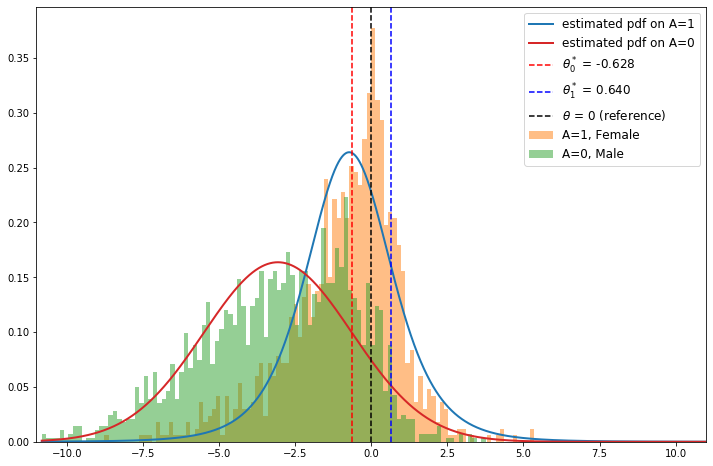

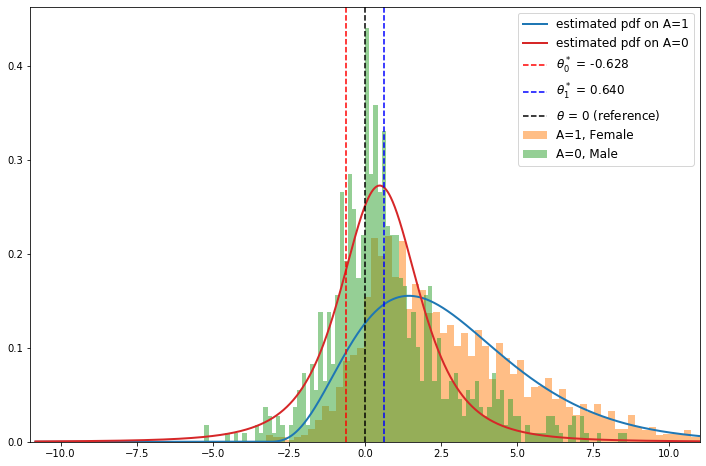

In [28]:
dist_test_wrt_y(train_logit, train_label, train_sens, '0', np.array([[-0.62794166],
       [ 0.64029629]]),\
          DATANAME, sample_config, dist_config, logit_form = True, \
          save_fig = True);

dist_test_wrt_y(train_logit, train_label, train_sens, '1', np.array([[-0.62794166],
       [ 0.64029629]]),\
          DATANAME, sample_config, dist_config, logit_form = True, \
          save_fig = True);
